**Contexto**

Trabalhamos em uma vinícola e esta começou a detectar alguns problemas na qualidade do vinho e do suco de uva produzidos. Por isso, uma pessoa profissional na área de agronomia começou a tirar fotos das folhas de videira e identificou três problemas diferentes nas folhas.

Por conta disso, foi determinado que seria interessante construir algo capas de realizar a classificação dos problemas nas folhas de videira rapidamente.

Para isto, iremos construir uma **rede neural convolucional**, que é conhecida por fazer esse processo de classificação de imagens de maneira eficiente.

[Download Dataset Videiras](https://cdn3.gnarususercontent.com.br/3773-tensorflow-keras-imagens-redes-convolucionais/Projeto/uvas.zip)

In [31]:
import pathlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras

In [32]:
data_dir = pathlib.Path('uvas')

# Glob adquire todos os arquivos com a extensão jpg e faz a contagem
data_dir_lenght = len(list(data_dir.glob('*/*.jpg')))

print('Quantidade de imagens no diretório:', data_dir_lenght)

Quantidade de imagens no diretório: 1600


Há 4 subpastas que se referenciam as classes que a videira pode ter:

Sarampo negro, podridão negra, uvas saudáveis, ferrugem da folha

In [33]:
subfolders = [file.name for file in data_dir.iterdir() if file.is_dir()]
subfolders

['BlackMeasles', 'BlackRot', 'HealthyGrapes', 'LeafBlight']

In [34]:
# Adquire todos os caminhos para as imagens da subpasta
leafblight = list(data_dir.glob('LeafBlight/*'))

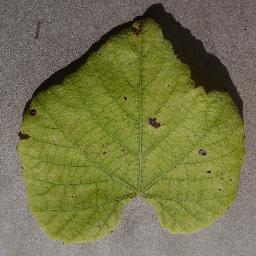

In [35]:
# Exibe a primeira imagem
Image.open(leafblight[0])

### Carregando as imagens (manualmente)

In [36]:
images, labels = [], []

for dir in data_dir.iterdir():
    images_path = data_dir.glob(dir.name + '/*')
    for img_path in images_path:
        file_img = Image.open(img_path)
        images.append(file_img)
        labels.append(dir.name)

In [37]:
images = np.array(images)
labels = np.array(labels)

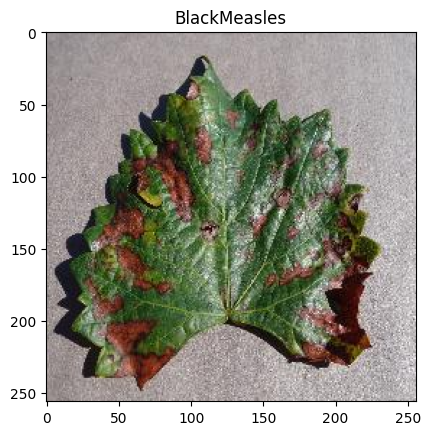

In [38]:
plt.title(labels[0])
plt.imshow(images[0])

### Explorando e visualizando os dados

A expressão *data_dir / subfolder* realiza uma concatenação dos caminhos (paths) de maneira mais elegante.

Seria a mesma coisa com *os.path.join(data_dir, subfolder)*, porém a opção acima é menos verbosa.

In [39]:
for subfolder in subfolders: # Itera por todas as subpastas
    path = data_dir / subfolder # concatena o diretório base com a subpasta
    images_path = list(path.glob('*.jpg')) # Adquire todos os caminhos que tenham a extensão jpg
    print(f'{subfolder} tem {len(images_path)} imagens.') # Conta a quantidade de paths de imagens jpg na pasta

    if images_path:
        file_img = Image.open(images_path[0]) # Adquire a primeira imagem para verificar a resolução
        img_array = np.array(file_img)
        print(f'Resolução das imagens:', img_array.shape, '\n')

BlackMeasles tem 400 imagens.
Resolução das imagens: (256, 256, 3) 

BlackRot tem 400 imagens.
Resolução das imagens: (256, 256, 3) 

HealthyGrapes tem 400 imagens.
Resolução das imagens: (256, 256, 3) 

LeafBlight tem 400 imagens.
Resolução das imagens: (256, 256, 3) 



Temos 400 elementos para cada uma das classes, portanto, nossos dados estão **balanceados**.

Todas as imagens tem 256x256 pixels, com 3 canais de cor, no caso, RGB.

**Retorno do shape**
- (256, 256, 3) significa: (altura, largura, canais)

Por exemplo, para um caso de (4, 4, 3) 4x4 pixels e 3 canais:

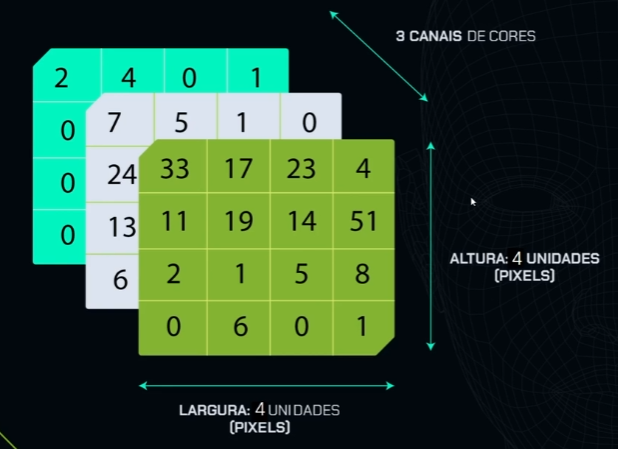

Chamamos esta estrutura de dados de **tensor**.

### Carregamento das imagens em lotes utilizando Keras/Tensorflow

Não podemos carregar as imagens todas de uma única vez, isto porque podemos exceder o número de memória RAM disponível em nossa máquina.

Portanto, precisaremos carregar os dados em lotes (*batchs*).

#### Importante:
- Isto é importante para evitar que o treinamento da rede neural **pare na metade devido à falta de recursos computacionais**. Carregar todos os dados de uma vez pode **extrapolar os recursos computacionais disponíveis, interrompendo o treinamento da rede neural**.

In [40]:
BATCH_SIZE = 64
HEIGHT, WIDTH, _ = images[0].shape # (256,256,3) ou height, width e channels
SEED = 847

Podemos utilizar o próprio Keras/Tensorflow para carregar o dataset das imagens.

In [41]:
train = keras.utils.image_dataset_from_directory(
    data_dir, # caminho até as pastas com as imagens
    validation_split=0.2, # tamanho da validação
    subset='training', # parâmetros disponíveis: training, validation e both
    seed=SEED, # seed para ter reprodutibilidade
    image_size=(WIDTH, HEIGHT), # dimensão das imagens
    batch_size=BATCH_SIZE, # tamanho do lote
    color_mode='grayscale') # Convertendo em escala de cinza (disponíveis: rgb, rgba, grayscale)

Found 1600 files belonging to 4 classes.
Using 1280 files for training.


In [42]:
validation = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')

Found 1600 files belonging to 4 classes.
Using 320 files for validation.


Verificando o nome das classes

In [43]:
train.class_names

['BlackMeasles', 'BlackRot', 'HealthyGrapes', 'LeafBlight']

**Explicação do Batch Size**

É necessário analisar alguns fatores para escolher o número do lote:

- **Capacidade de Memória**: O Batch size é limitado pela quantidade de memória disponível na sua GPU ou CPU. Um batch size maior consome mais memória, mas pode acelerar o processo de treinamento, pois realiza menos atualizações dos pesos por época.
- **Estabilidade e Desempenho do Modelo**: Batch sizes maiores podem levar a uma estimativa mais estável, mas às vezes com a desvantagem de potencialmente alcançar mínimos locais menos ótimos no espaço de erro do modelo. Batch sizes menores oferecem uma estimativa mais ruidosa, o que pode ajudar a escapar de mínimos locais, mas também pode tornar o treinamento menos estável.
- **Eficiência de Treinamento**: Em geral, batch sizes maiores permitem que vocÊ faça uso mais eficiente das capacidades de processamento paralelo das GPUs.

Um ponto de partida comum é experimentar com um batch size de **32** a **64** e ajustar a partir daí baseado no desempenho e capacidade da máquina.

Caso for observado que o **treinamento é muito lento, aumentar o batch size** pode ser uma boa ideia. Por outro lado, se for encontrado **problemas de memória ou se o modelo não estiver aprendendo bem**, pode ser necessário **reduzir o batch size**.

In [44]:
# Visualizando os dados do 1° lote:
for images, labels in train.take(1):
    print(images.shape) # 64 imagens (por lote), 256 x 256 pixels, com 1 canal (escala de cinza)
    print(labels.shape)
    print(labels)

(64, 256, 256, 1)
(64,)
tf.Tensor(
[0 1 2 2 3 2 1 3 1 0 0 1 0 3 1 3 1 1 1 3 3 2 0 0 3 3 1 3 0 2 2 3 2 2 1 1 2
 2 2 0 3 0 0 2 3 2 2 1 1 3 0 2 1 0 2 3 2 3 2 0 0 2 0 2], shape=(64,), dtype=int32)


### Criando o modelo (perceptron de múltiplas camadas)

In [45]:
keras.utils.set_random_seed(SEED) # Reprodutibilidade nos modelos Keras

In [46]:
model = keras.Sequential()

**Camada de entrada**

A camada de entrada define a forma dos dados que serão alimentados na rede. No nosso caso, estamos trabalhando com imagens de tamanho 256x256 pixels, com 3 canais de cor (RGB). Esta camada não realiza nenhum processamento nos dados, mas **informa ao modelo o formato/dimensão dos dados de entrada**.

In [47]:
# Definindo a dimensão da entrada
model.add(keras.layers.Input(shape=(256,256,1))) # Com 1 canal pois é necessário especificar as 3 dimensões, porém estará em escala de cinza

**Camada de Reescalonamento**

As imagens geralmente tem valores presentes em cada posição entre 0 e 255. Para facilitar o processamento e melhorar a performance do modelo, escalamos esses valores para a faixa de 0 a 1 (dividindo as imagens por 255). A camada *Rescaling* divide o valor presente em cada posição por 255.

In [48]:
# Normalização das imagens: Para redimensionar uma entrada no intervalo [0, 255] para estar no intervalo [0, 1], você passaria scale=1./255.
model.add(keras.layers.Rescaling(1./255))

**Camada de Achatamento**

A camada *Flatten* converte a matriz de pixels 2D da imagem em um vetor 1D. Este é um passo necessário para conectar a camada de entrada (que é uma imagem) às camadas densas (fully connected layers) subsequentes. Essencialmente, ela pega a estrutura em grade da imagem e a "achata" em uma única linha de dados para transmitir à próxima camada.

In [49]:
# Iremos achatar a imagem de uma matriz bi-dimensional para um vetor (unidimensional)
model.add(keras.layers.Flatten())

**Camada Densa com 128 Neurônios**

Esta é uma camada densa, ou totalmente conectada, com 128 neurônios. Cada neurônio recebe a entrada de todos os neurônios da camada anterior (neste caso, a camada de *Flatten*). A função de ativação *ReLU (Rectified Linear Unit)* ajuda a rede a capturar padrões complexos nos dados.

**O que é a função de ativação ReLU?**

Significa Unidade Linear Retificada. Sua fórmula é bastante simples: se a entrada é positiva, a função retorna o valor; se é negativa, retorna zero.

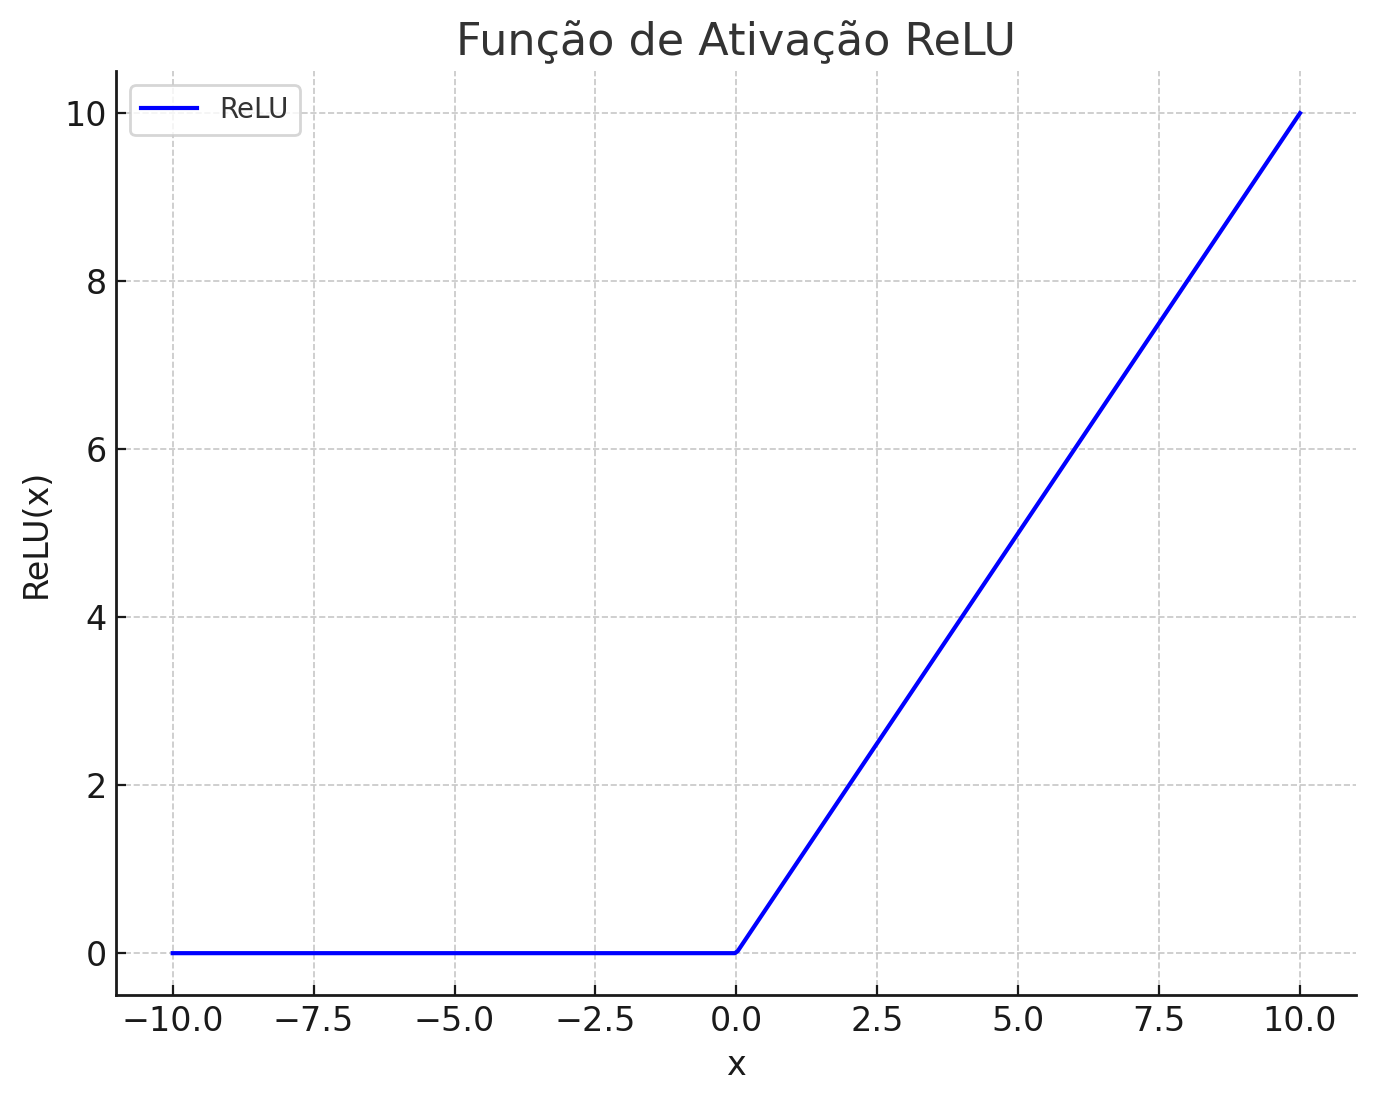

*ReLU resolve o problema do gradiente desaparecido:*

Em redes profundas, o gradiente (a medida de quanto precisamos atualizar os pesos) pode se tornar muito pequeno, dificultando o aprendizado. ReLU ajuda a mitigar esse problema.

In [50]:
# Construindo a rede neural como uma camada densa (camada oculta)
model.add(keras.layers.Dense(128, activation='relu'))

**Camada de Saída com 4 Neurônios**

A última camada é outra camada densa, mas desta vez com 4 neurônios. Esta camada é a saída da rede e utiliza a função de ativação *softmax*. A *softmax* transforma os valores de saída em probabilidades que somam 1, o que é útil para tarefas de classificação onde queremos determinar a probabilidade de cada classe. Neste exemplo, presumimos que estamos classificando as imagens em uma de quatro possíveis categorias.

**O que é a Softmax?**

É outra função de ativação, mas com um propósito diferente. Enquanto ReLU é ótima para camadas ocultas, Softmax é usada na camada de saída de modelos de classificação, onde precisamos de probabilidades para cada classe.

Softmax transforma os logits (valores brutos de saída de neurônios) em probabilidades, garantindo que todas as saídas somem 1. É ideal para quando temos mais de duas classes (multiclasse).

In [51]:
# Camada de saída com softmax (para problemas de classificação multiclasse, pois temos 4 classes)
model.add(keras.layers.Dense(4, activation='softmax'))

**Compilando o modelo**

In [52]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(), # Função de perda/custo irá verificar como a rede neural está evoluindo ao decorrer do treinamento
              metrics=['accuracy'])

**Treinando a rede neural**

In [53]:
history = model.fit(
    train,
    validation_data=validation,
    epochs=10
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.2580 - loss: 17.7964 - val_accuracy: 0.2406 - val_loss: 5.0620
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3923 - loss: 3.2060 - val_accuracy: 0.6281 - val_loss: 0.9264
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5958 - loss: 1.0621 - val_accuracy: 0.5906 - val_loss: 0.9180
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6440 - loss: 0.9327 - val_accuracy: 0.6281 - val_loss: 0.8587
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6183 - loss: 0.9764 - val_accuracy: 0.6031 - val_loss: 1.4778
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6561 - loss: 0.9356 - val_accuracy: 0.6313 - val_loss: 1.1472
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5488 - loss: 1.4185 - val_accuracy: 0.4781 - val_loss: 2.2001
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5116 - loss: 1.8261 - val_accuracy: 0.6031 - 

Flatten é 196608 pois é o resultado do produto das dimensões 256 * 256 * 3.

In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,167,758 (96.01 MB)

 Trainable params: 8,389,252 (32.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,778,506 (64.00 MB)

**Visualizando os resultados**

In [55]:
# Visualizando todos os atributos e seus valores
history.__dict__

{'params': {'verbose': 'auto', 'epochs': 10, 'steps': 20},
 '_model': <Sequential name=sequential_1, built=True>,
 'history': {'accuracy': [0.29296875,
   0.44921875,
   0.610156238079071,
   0.641406238079071,
   0.6031249761581421,
   0.6265624761581421,
   0.524218738079071,
   0.514843761920929,
   0.6351562738418579,
   0.6890624761581421],
  'loss': [10.99333381652832,
   2.342977523803711,
   1.0307689905166626,
   0.9129546880722046,
   1.0603851079940796,
   0.9921725988388062,
   1.5062183141708374,
   1.6768205165863037,
   1.1348286867141724,
   0.9325418472290039],
  'val_accuracy': [0.24062499403953552,
   0.628125011920929,
   0.590624988079071,
   0.628125011920929,
   0.6031249761581421,
   0.6312500238418579,
   0.4781250059604645,
   0.6031249761581421,
   0.671875,
   0.559374988079071],
  'val_loss': [5.062021732330322,
   0.9264003038406372,
   0.9180291295051575,
   0.8586904406547546,
   1.477843999862671,
   1.1472108364105225,
   2.20009183883667,
   1.2666642

**Acurácia por época**

Text(0, 0.5, 'Acurácia')

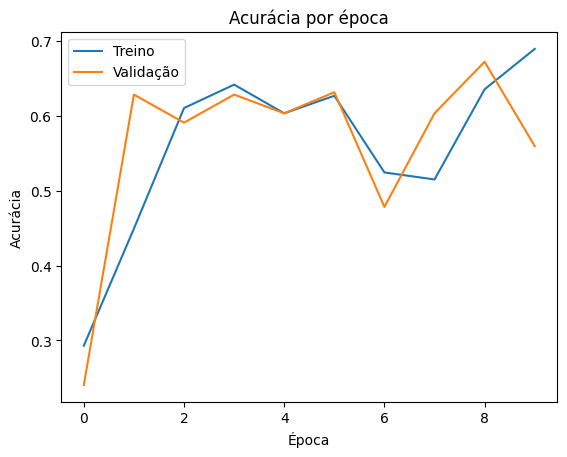

In [56]:
plt.title("Acurácia por época")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Treino', 'Validação'])
plt.xlabel("Época")
plt.ylabel("Acurácia")

Text(0, 0.5, 'Perda')

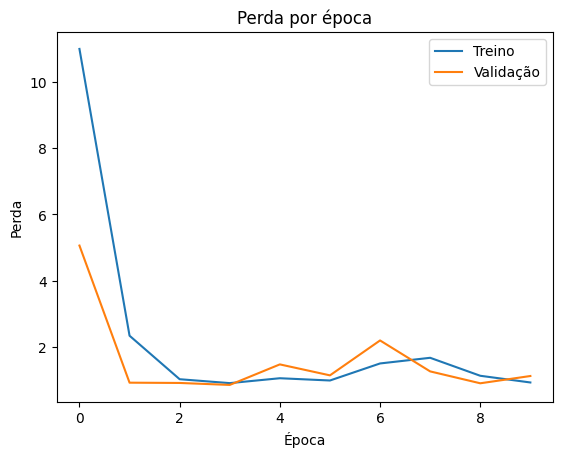

In [57]:
plt.title("Perda por época")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Treino', 'Validação'])
plt.xlabel("Época")
plt.ylabel("Perda")

### Estruturando uma **Rede Neural Convolucional (CNN)**

Iremos utilizar o mesmo modelo anterior, porém adicionaremos algumas camadas convolucionais.

- A camada convolucional passará **filtros** pelas imagens, é possível definir a quantidade de filtros da camada convolucional com o parâmetro **filters**.
- A quantidade de filtros determinará a quantidade de versões diferentes geradas da imagem (por exemplo, se houver 32 filtros, irá ser gerado 32 versões diferentes da imagem).
- O tamanho desses filtros contém um tamanho e podem ser definidos pelo parâmetro **kernel_size**.

#### **O que é uma Camada Convolucional?**

É um tipo especial de rede neural projetado para **trabalhar com dados em formato de imagem**. Elas são amplamente usadas em tarefas de visão computacional, como detecção de objetos, classificação de imagens, reconhecimento facial, etc.

As CNNs são boas com imagens pois conseguem identificar **padrões locais** (como bordas, texturas e formas) e, depois, combiná-los para reconhecer padrões mais complexos (como rostos ou carros). Isso é feito usando operações chamadas **convoluções** e **pooling**.

#### **O que é o Conv2D?**

É uma camada em redes neurais convolucionais que aplica a operação de convolução em imagens 2D (duas dimensões: largura e altura). A convolução ajuda a destacar padrões locais em uma imagem.

**Como funciona?**
- Imagine que uma imagem é uma tabela de números (matriz) onde cada número representa a intensidade de um pixel (em preto e branco) ou valores RGB (em cores).
- O Conv2D usa pequenos filtros (também chamados de **kernels**), que são matrizes menores, como uma lupa, para "varrer" a imagem.
- Cada filtro realiza uma multiplicação dos números dentro de sua área e depois soma o resultado. O resultado dessa operação destaca características específicas da imagem, como bordas ou texturas.
- O filtro é "movido" pela imagem realizando essas operações matemáticas e repete o processo para cada posição.

Isso resulta em uma nova matriz, chamada de **mapa de características (feature map)**, que destaca os padrões encontrados pelo filtro.

#### **O que é o MaxPooling2D?**

O MaxPooling2D (agregação, redução) é uma operação usada para **reduzir a resolução** de um mapa de características. Ele reduz a dimensão (resolução) da imagem de entrada (mapa de características), preservando as informações mais importantes.

Isto é necessário pois, a quantidade de filtros determinará a quantidade de versões diferentes geradas da imagem, porém ao final deste processo haverá muita informação, onde é necessário reduzir a quantidade de informação preservando as mais importantes.

**Como funciona?**

- O MaxPooling divide a imagem em blocos menores (por exemplo, blocos de 2x2).
- Dentro de cada bloco, ele pega o maior valor e descarta os outros valores.
- No final, esse valor máximo é usado para criar um novo mapa de características reduzido.

**Por que usar?**

- Reduz a complexidade computacional.
- Remove ruídos desnecessários, mantendo os padrões principais.
- Diminui a quantidade de parâmetros e cálculos na rede, o que pode acelerar o treinamento e reduzir o risco de overfitting.
- Ajuda a tornar a rede mais robusta a pequenas translações e distorções na imagem de entrada, pois ele se concentra nas características mais importantes.
- Ao selecionar o valor máximo em cada região, o MaxPooling destaca as características mais salientes da imagem, permitindo que as próximas camadas da rede se concentrem em informações mais importantes.

#### **Em resumo, conectando tudo**

Uma CNN típica combina **Conv2D** e **MaxPooling2D** para extrair padrões importantes de uma imagem enquanto reduz sua resolução. O fluxo básico é:

- Imagem de entrada -> Exemplo: foto de um gato (64 x 64).
- Conv2D -> Detecta padrões locais como bordas.
- MaxPooling2D -> Reduz a resolução para destacar apenas os padrões amis importantes.
- Repete os passos 2 e 3 para construir um entendimento mais complexo da imagem.
- Por fim, as informações processadas são passadas para **camadas densas (Dense)** para tomar decições, como classificar a imagem como "gato" ou "cachorro".

In [65]:
# Para agilizar, iremos criar o modelo em um único bloco de código
conv_model = keras.Sequential([
    keras.layers.Input(shape=(256,256,1)),
    keras.layers.Rescaling(1./255),

    keras.layers.Conv2D(32, (3,3), activation='relu'), # Adicionando camada convolucional com 32 filtros de 3x3 pixels
    keras.layers.MaxPooling2D(pool_size=(2,2)), # Reduz para metade da resolução

    keras.layers.Conv2D(64, (3,3), activation='relu'), # 64 filtros de 3x3 pixels
    keras.layers.MaxPooling2D(pool_size=(2,2)), # Reduz novamente

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

**Compilando o modelo**

In [66]:
conv_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(), # Função de perda/custo irá verificar como a rede neural está evoluindo ao decorrer do treinamento
              metrics=['accuracy'])

In [67]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath='best_conv_model.keras', save_best_only=True)
]

history_conv_model = conv_model.fit(
    train,
    validation_data=validation,
    callbacks=callbacks,
    epochs=10
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2347 - loss: 7.2610 - val_accuracy: 0.2844 - val_loss: 1.2156
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3747 - loss: 1.1530 - val_accuracy: 0.6719 - val_loss: 0.9467
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7756 - loss: 0.7102 - val_accuracy: 0.7500 - val_loss: 0.6253
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8974 - loss: 0.3229 - val_accuracy: 0.8062 - val_loss: 0.5248
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9632 - loss: 0.1561 - val_accuracy: 0.8438 - val_loss: 0.4399
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9884 - loss: 0.0734 - val_accuracy: 0.8000 - val_loss: 0.5549
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9952 - loss: 0.0413 - val_accuracy: 0.8313 - val_loss: 0.4691
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9987 - loss: 0.0175 - val_accuracy: 0.8062 - val_loss:

In [68]:
conv_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,528,526 (360.60 MB)

 Trainable params: 31,509,508 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,019,018 (240.40 MB)

**Acurácia por época**

Text(0, 0.5, 'Acurácia')

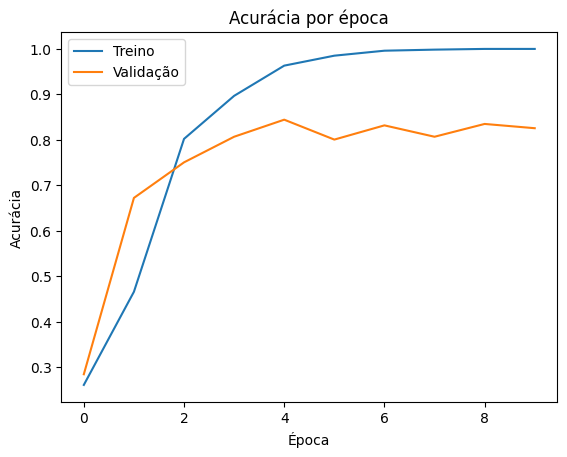

In [69]:
plt.title("Acurácia por época")
plt.plot(history_conv_model.history['accuracy'])
plt.plot(history_conv_model.history['val_accuracy'])
plt.legend(['Treino', 'Validação'])
plt.xlabel("Época")
plt.ylabel("Acurácia")

**Perda por época**

Text(0, 0.5, 'Perda')

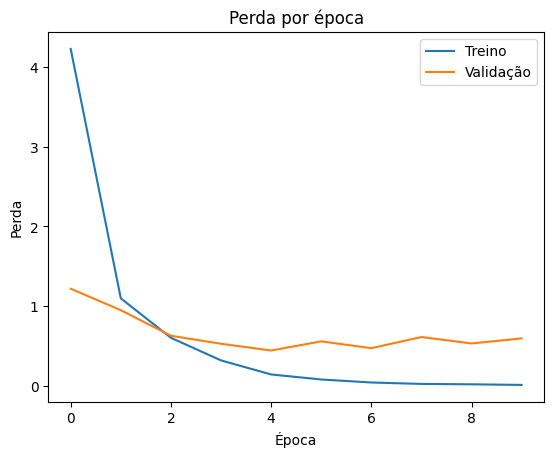

In [70]:
plt.title("Perda por época")
plt.plot(history_conv_model.history['loss'])
plt.plot(history_conv_model.history['val_loss'])
plt.legend(['Treino', 'Validação'])
plt.xlabel("Época")
plt.ylabel("Perda")